In [1]:
import os

from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from Standard_functions import get_user_split_data, plot_fit_score_pred,fit_score_pred_G_NB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, f1_score
import copy

import warnings

warnings.filterwarnings('always') 

In [2]:
os.chdir('../Data/')

## Department Ordinal values

In [3]:
df = pd.read_pickle('full_features')
df.drop('max_order_number',axis=1,inplace=True)
ord_prod_prior_df = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
products.drop(['aisle_id','product_name'],axis=1,inplace=True)
ord_prod_prior_df = ord_prod_prior_df.merge(products,on='product_id')

In [4]:
reordered_by_department = ord_prod_prior_df.groupby('department_id',as_index=False)['reordered'].sum()
reordered_by_department.columns = ['department_id','reordered_by_department']

In [5]:
ordinal_by_department = (reordered_by_department.sort_values('reordered_by_department')
                    .reset_index(drop=True).reset_index())
ordinal_by_department.drop('reordered_by_department',axis=1,inplace=True)
ordinal_by_department.columns = ['ordinal_by_department','department_id']

In [6]:
ordinal_by_department = ordinal_by_department.merge(products,on='department_id')

In [7]:
ordinal_by_department.drop('department_id',inplace=True,axis=1)

In [8]:
df = df.merge(ordinal_by_department,on='product_id')

In [9]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df, val_size=.2, seed=42)
print('Gaussian Naive Bayes:')
fit_score_pred_G_NB(X_tr, X_val, y_tr, y_val)

Gaussian Naive Bayes:
Our f1-score is 0.4004355842111505
And we've predicted 1491923 non-re-orders and 203756 re-orders.


## ROC AUC

In [10]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)

In [11]:
clf = GaussianNB(var_smoothing=1e-9)
clf.fit(X_tr, y_tr)
probabilities = clf.predict_proba(X_val)[:,1]


In [12]:
fpr, tpr, thresholds = roc_curve(y_val,probabilities)

ROC AUC score =  0.7960081362603056


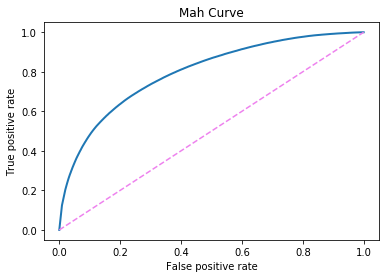

In [13]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Mah Curve');
print("ROC AUC score = ", roc_auc_score(y_val, probabilities))

## Messing with thresholds

In [14]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)

In [15]:
clf = GaussianNB(var_smoothing=1e-9)
clf.fit(X_tr, y_tr)
probabilities = clf.predict_proba(X_val)[:,1]


In [16]:
roc_auc_score(y_val,probabilities)

0.7960081362603056

In [17]:
fpr, tpr, thresholds = roc_curve(y_val,probabilities)

In [18]:
probs = pd.DataFrame(probabilities)
probs.columns = ['score']
test = copy.deepcopy(probs)

In [19]:
threshold = np.linspace(.1,.9,40)
dict_thresholdf1 = dict()

for i in threshold:
    test = copy.deepcopy(probs)
    conditions = [
    (test.score > i),
    (test.score < i)
    ]
    choices = [1,0]
    test.score = np.select(conditions, choices)
    dict_thresholdf1[i] = f1_score(y_val,test)

dict_thresholdf1

{0.1: 0.39544848179657754,
 0.12051282051282051: 0.3978567710168517,
 0.14102564102564102: 0.3990877728080045,
 0.16153846153846155: 0.40005019450370183,
 0.18205128205128207: 0.4005778096112524,
 0.20256410256410257: 0.40108892038121957,
 0.2230769230769231: 0.40124124173429054,
 0.24358974358974358: 0.4013690043875795,
 0.2641025641025641: 0.40150828578099224,
 0.2846153846153846: 0.4014893412373378,
 0.30512820512820515: 0.4015791406536907,
 0.32564102564102565: 0.401531827019641,
 0.34615384615384615: 0.4013353019814909,
 0.3666666666666667: 0.4013428757319453,
 0.38717948717948714: 0.40127148378177396,
 0.4076923076923077: 0.4009638046583892,
 0.42820512820512824: 0.40083979328165376,
 0.4487179487179487: 0.4005301792282592,
 0.46923076923076923: 0.40048584599003156,
 0.4897435897435898: 0.4006011302108258,
 0.5102564102564102: 0.40039342738481576,
 0.5307692307692308: 0.40008906557181184,
 0.5512820512820513: 0.3998842987384742,
 0.5717948717948718: 0.3996972987201,
 0.5923076923